In [9]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Preprocessing Data

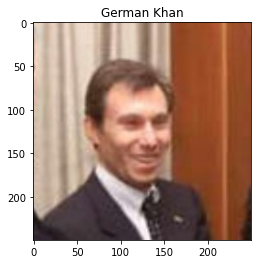

In [56]:
# Look at arbitrary images in the dataset
for dirName, subdirList, fileList in os.walk('./lfw/German_Khan'):
    for f in fileList:
        img = cv2.imread(os.path.join(dirName, f))
        img = img[:,:,::-1]
        plt.imshow(img)
        plt.title(' '.join(dirName.split('/')[-1].split('_')))

In [76]:
img_count = 0
ppl_count = 0
for dirName, subdirList, fileList in os.walk('./lfw'):
    #print(dirName, fileList)
    if dirName != './lfw':
        ppl_count += 1
    for f in fileList:
        if f.endswith('.jpg'):
            img_count += 1
print(img_count)
print(ppl_count)

13233
5749


In [74]:
c = 0
n = 1
with open('lfw-names.txt',encoding='utf-8') as f:
    s = f.readline()
    while s != '':
        n += 1
        #print(" ".join(s.split())[-1])
        c += int(" ".join(s.split())[-1])
        s = f.readline()
print(c,n)

9463 5750
